In [1]:
import pandas as pd
from scipy.stats import wilcoxon, mannwhitneyu, ttest_ind, ttest_rel
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from scipy.stats import boxcox
import numpy as np
import statsmodels.api as sm 
from statsmodels.formula.api import ols

PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"

BOF_mean_times = "OFT_Frame_Label_ROI_percs_meantimes.csv"#"BOF_Cen_vs_Surr_mean_times.csv"
EPM_mean_times = "HoldoutMice_EPM_ROI_perc_mean_time_5_minutes.csv"

BOF_roi_seg_lengths = "BOF_avg_roi_seg_length.csv"
EPM_roi_seg_lengths = "EPM_avg_roi_seg_length.csv"

BOF_roi_percentages = "OFT_Frame_Label_ROI_percs_meantimes.csv"
EPM_roi_percentages = "HoldoutMice_EPM_ROI_perc_mean_time_5_minutes.csv"

BOF_Periphery_scores = "net_{}_scores_BOF_surround_scores_over_time_w_HC_mean.csv"
EPM_CA_scores = "net_{}_scores_EPM_closed_arm_scores_over_time_w_HC.csv"

def reshape_df(df,data_idxs,group):
    mice = df.mouse
    new_structure = np.zeros((len(data_idxs)*len(mice),4))*np.nan
    for idx, mouse in enumerate(mice):
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),0] = df[data_idxs].values[idx,:].copy()
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),1] = idx + 1
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),2] = data_idxs
        new_structure[(len(data_idxs)*idx):(len(data_idxs)*(idx+1)),3] = group
    return pd.DataFrame(new_structure,columns=["score","mouse","time","group"])

### Figure 3A

In [4]:
proj_file = PROJECT_PATH + "FLX_Holdout_Projections_bxcx.csv"
df = pd.read_csv(proj_file)

mouse_encoder = OrdinalEncoder().fit(df.mouse.values.reshape(-1,1))
df_me = {
    "n1_scores":np.hstack([df[df.flx==1]["net 1 scores"],
                           df[df.flx==0]["net 1 scores"]]),
    
    "n2_scores":np.hstack([df[df.flx==1]["net 2 scores"],
                           df[df.flx==0]["net 2 scores"]]),
    
    "mouse":np.hstack([mouse_encoder.transform(df[df.flx==1]["mouse"].values.reshape(-1,1)).squeeze(),
                       mouse_encoder.transform(df[df.flx==0]["mouse"].values.reshape(-1,1)).squeeze()]).astype(int)+1,
    
    "flx":np.hstack([df[df.flx==1]["flx"],df[df.flx==0]["flx"]]).astype(int),
    
    "time":np.hstack([df[df.flx==1]["time"],df[df.flx==0]["time"]]),#MinMaxScaler().fit_transform(np.hstack([df[df.flx==1]["time"],df[df.flx==0]["time"]]).astype(float).reshape(-1,1)).squeeze(),
    
}

df_me = pd.DataFrame.from_dict(df_me)

stacks = []
time_scaler = MinMaxScaler()

for mouse in np.unique(df_me.mouse):
    for drug in np.unique(df_me.flx):
        mask = np.logical_and(df_me.mouse==mouse,df_me.flx==drug)
        
        #We want 60 minutes of Data
        for i in range(60):
            time_mask = np.logical_and(df_me.time > i*60, df_me.time <= (i+1)*60)
            temp_mask = np.logical_and(time_mask,mask).values
            
            n1_mean_score = np.nanmean(df_me[temp_mask==1].n1_scores.values)
            n2_mean_score = np.nanmean(df_me[temp_mask==1].n2_scores.values)
            
            stacks.append(np.array([n1_mean_score,n2_mean_score,mouse,drug,i]))
            
            
df_stats = pd.DataFrame(stacks,columns=["n1_scores","n2_scores","mouse","flx","minute"])

df_stats.minute = time_scaler.fit_transform(df_stats.minute.values.reshape(-1,1)).squeeze()
df_stats.n1_scores = boxcox(20*df_stats.n1_scores)[0]
df_stats.n2_scores = boxcox(20*df_stats.n2_scores)[0]

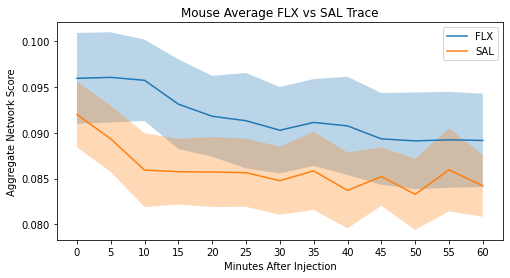

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,3.080009,59,295,0.052204,4.054338,7.825426e-16,0.014101,0.049029,0.068460
1,flx,4.293213,1,5,4.293213,9.165288,2.916734e-02,0.029167,0.067047,1.000000
2,minute * flx,0.888407,59,295,0.015058,1.136061,2.466370e-01,0.368043,0.014653,0.069951


In [14]:
plt.figure(figsize=(8,4))
score_key = "net 1 scores"
all_mice_flx = []
all_mice_sal = []
for idx,mouse in enumerate(np.unique(df.mouse)):
        
    flx_points = df[np.logical_and(df.flx==1,df.mouse==mouse)][[score_key,"time","expDate"]]
    sal_points = df[np.logical_and(df.flx==0,df.mouse==mouse)][[score_key,"time","expDate"]]
    
    flx_m_avg = []
    sal_m_avg = []
    for i in range(13):
        flx_time_mask = np.logical_and(flx_points.time >= i*300, flx_points.time < (i+1)*300)
        sal_time_mask = np.logical_and(sal_points.time >= i*300, sal_points.time < (i+1)*300)
        
        flx_m_avg.append(np.mean(flx_points[score_key].to_numpy()[flx_time_mask==1]))
        sal_m_avg.append(np.mean(sal_points[score_key].to_numpy()[sal_time_mask==1]))
    

        
    
    all_mice_flx.append(flx_m_avg)
    all_mice_sal.append(sal_m_avg)
    
flx_mean = np.mean(all_mice_flx,axis=0)
flx_stderr = np.std(all_mice_flx,axis=0)/np.sqrt(6)

sal_mean = np.mean(all_mice_sal,axis=0)
sal_stderr = np.std(all_mice_sal,axis=0)/np.sqrt(6)

plt.plot(flx_mean,label="FLX")
plt.fill_between(range(13),flx_mean + flx_stderr,flx_mean-flx_stderr,alpha=0.3)

#plt.fill_between(np.mean(all_mice_flx,axis=0) + 
plt.plot(np.mean(all_mice_sal,axis=0),label="SAL")
plt.fill_between(range(13),sal_mean + sal_stderr,sal_mean-sal_stderr,alpha=0.3)

plt.xticks(range(13), range(0,61,5))
plt.xlabel("Minutes After Injection")
plt.ylabel("Aggregate Network Score".format(score_key))
plt.title("Mouse Average FLX vs SAL Trace")
plt.legend()
#plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/FLX_Mouse_Average_Trace.svg")
plt.show()

from pingouin import rm_anova
rm_anova(dv="n1_scores",within=["minute","flx"],subject="mouse",data=df_stats)

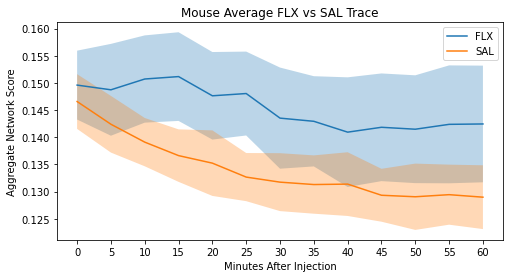

,Source,SS,ddof1,ddof2,MS,F,p-unc,p-GG-corr,ng2,eps
0,minute,13.034927,59,295,0.220931,3.851086,9.982110e-15,0.015017,0.056540,0.072691
1,flx,20.771919,1,5,20.771919,5.755776,6.168788e-02,0.061688,0.087175,1.000000
2,minute * flx,4.293664,59,295,0.072774,1.356014,5.447795e-02,0.279306,0.019358,0.076220


In [15]:
plt.figure(figsize=(8,4))
score_key = "net 2 scores"
all_mice_flx = []
all_mice_sal = []
for idx,mouse in enumerate(np.unique(df.mouse)):
        
    flx_points = df[np.logical_and(df.flx==1,df.mouse==mouse)][[score_key,"time","expDate"]]
    sal_points = df[np.logical_and(df.flx==0,df.mouse==mouse)][[score_key,"time","expDate"]]
    
    flx_m_avg = []
    sal_m_avg = []
    for i in range(13):
        flx_time_mask = np.logical_and(flx_points.time >= i*300, flx_points.time < (i+1)*300)
        sal_time_mask = np.logical_and(sal_points.time >= i*300, sal_points.time < (i+1)*300)
        
        flx_m_avg.append(np.mean(flx_points[score_key].to_numpy()[flx_time_mask==1]))
        sal_m_avg.append(np.mean(sal_points[score_key].to_numpy()[sal_time_mask==1]))
    

        
    
    all_mice_flx.append(flx_m_avg)
    all_mice_sal.append(sal_m_avg)
    
flx_mean = np.mean(all_mice_flx,axis=0)
flx_stderr = np.std(all_mice_flx,axis=0)/np.sqrt(6)

sal_mean = np.mean(all_mice_sal,axis=0)
sal_stderr = np.std(all_mice_sal,axis=0)/np.sqrt(6)

plt.plot(flx_mean,label="FLX")
plt.fill_between(range(13),flx_mean + flx_stderr,flx_mean-flx_stderr,alpha=0.3)

#plt.fill_between(np.mean(all_mice_flx,axis=0) + 
plt.plot(np.mean(all_mice_sal,axis=0),label="SAL")
plt.fill_between(range(13),sal_mean + sal_stderr,sal_mean-sal_stderr,alpha=0.3)

plt.xticks(range(13), range(0,61,5))
plt.xlabel("Minutes After Injection")
plt.ylabel("Aggregate Network Score".format(score_key))
plt.title("Mouse Average FLX vs SAL Trace")
plt.legend()
#plt.savefig("/hpc/home/mk423/Anxiety/FullDataWork/Figures/FLX_Mouse_Average_Trace.svg")
plt.show()

rm_anova(dv="n2_scores",within=["minute","flx"],subject="mouse",data=df_stats)

### Figure 3B

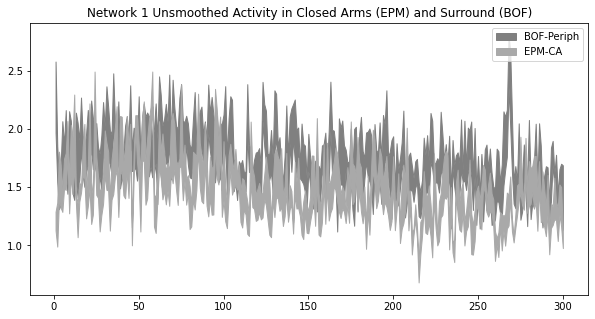

NETWORK 1 ANCOVA score ~ time + group
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.076
Method:                 Least Squares   F-statistic:                     169.6
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.71e-71
Time:                        11:47:59   Log-Likelihood:                -3707.7
No. Observations:                4125   AIC:                             7421.
Df Residuals:                    4122   BIC:                             7440.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

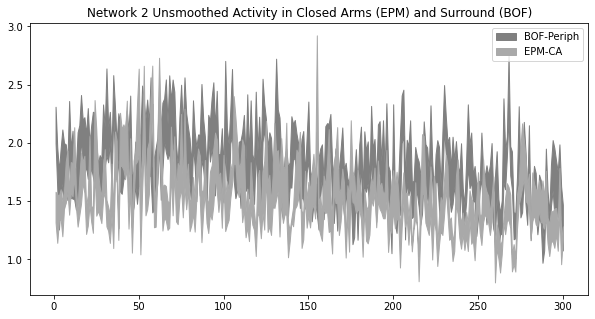

NETWORK 2 ANCOVA score ~ time + group
                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.070
Method:                 Least Squares   F-statistic:                     155.2
Date:                Mon, 13 May 2024   Prob (F-statistic):           1.01e-65
Time:                        11:47:59   Log-Likelihood:                -4073.9
No. Observations:                4125   AIC:                             8154.
Df Residuals:                    4122   BIC:                             8173.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     

In [40]:
#Network 1
first_half_idxs = np.arange(1,151).astype(str)
last_half_idxs = np.arange(151,301).astype(str)
all_idxs = np.arange(1,301).astype(str)

BOF_Periph = pd.read_csv(PROJECT_PATH + BOF_Periphery_scores.format(1))
EPM_CA = pd.read_csv(PROJECT_PATH + EPM_CA_scores.format(1))

plt.figure(figsize=(10,5))
plt.fill_between(np.arange(1,301),
                 np.mean(BOF_Periph[all_idxs]) + np.std(BOF_Periph[all_idxs])/np.sqrt(9),
                 np.mean(BOF_Periph[all_idxs]) - np.std(BOF_Periph[all_idxs])/np.sqrt(9),
                 color="grey",
                 label="BOF-Periph"
                )

plt.fill_between(np.arange(1,301),
                 np.mean(EPM_CA[all_idxs]) + np.std(EPM_CA[all_idxs])/np.sqrt(11),
                 np.mean(EPM_CA[all_idxs]) - np.std(EPM_CA[all_idxs])/np.sqrt(11),
                 color="darkgrey",
                 label="EPM-CA"
                )
plt.legend()
plt.title("Network 1 Unsmoothed Activity in Closed Arms (EPM) and Surround (BOF)")
plt.show()

EPM_stats_df = reshape_df(EPM_CA,all_idxs,0)
BOF_stats_df = reshape_df(BOF_Periph,all_idxs,1)
stats_df = pd.concat([EPM_stats_df,BOF_stats_df])

formula = "score ~ time + group"
model = ols(formula, data=stats_df).fit()
print("NETWORK 1 ANCOVA " + formula)
print(model.summary())
#Network 2
BOF_Periph = pd.read_csv(PROJECT_PATH + BOF_Periphery_scores.format(2))
EPM_CA = pd.read_csv(PROJECT_PATH + EPM_CA_scores.format(2))

plt.figure(figsize=(10,5))
plt.fill_between(np.arange(1,301),
                 np.mean(BOF_Periph[all_idxs]) + np.std(BOF_Periph[all_idxs])/np.sqrt(9),
                 np.mean(BOF_Periph[all_idxs]) - np.std(BOF_Periph[all_idxs])/np.sqrt(9),
                 color="grey",
                 label="BOF-Periph"
                )

plt.fill_between(np.arange(1,301),
                 np.mean(EPM_CA[all_idxs]) + np.std(EPM_CA[all_idxs])/np.sqrt(11),
                 np.mean(EPM_CA[all_idxs]) - np.std(EPM_CA[all_idxs])/np.sqrt(11),
                 color="darkgrey",
                 label="EPM-CA"
                )
plt.legend()
plt.title("Network 2 Unsmoothed Activity in Closed Arms (EPM) and Surround (BOF)")
plt.show()

EPM_stats_df = reshape_df(EPM_CA,all_idxs,0)
BOF_stats_df = reshape_df(BOF_Periph,all_idxs,1)
stats_df = pd.concat([EPM_stats_df,BOF_stats_df])

formula = "score ~ time + group"
model = ols(formula, data=stats_df).fit()
print("NETWORK 2 ANCOVA " + formula)
print(model.summary())

### Figure 3C

In [2]:
#Location Occupancy Stats
BOF_roi_percs = pd.read_csv(PROJECT_PATH + BOF_roi_percentages)
EPM_roi_percs = pd.read_csv(PROJECT_PATH + EPM_roi_percentages)

EPM_result = ttest_rel(EPM_roi_percs.ca_perc,
                       EPM_roi_percs.oa_perc,
                       alternative="greater")
    
BOF_result = ttest_rel(BOF_roi_percs["surround perc"],
                       BOF_roi_percs["center perc"],
                       alternative="greater")

print("EPM %oa vs %ca t={:.2f}, p={:.20f}".format(EPM_result.statistic,EPM_result.pvalue))
print("BOF %center vs %periphery t={:.2f}, p={:.20f}".format(BOF_result.statistic,BOF_result.pvalue))

BOF_lpb = pd.read_csv(PROJECT_PATH + BOF_roi_seg_lengths)
EPM_lpb = pd.read_csv(PROJECT_PATH + EPM_roi_seg_lengths)

EPM_vs_BOF_result = ttest_ind(EPM_lpb["mean consecutive oa windows"],
                              BOF_lpb["mean consecutive ctr windows"],
                              alternative="greater")

print("EPM vs BOF anxiogenic segment length t={:.2f}, p={:.8f}".format(EPM_vs_BOF_result.statistic,
                                                                      EPM_vs_BOF_result.pvalue))

EPM %oa vs %ca t=19.89, p=0.00000000113077201165
BOF %center vs %periphery t=29.76, p=0.00000000088233321220
EPM vs BOF anxiogenic segment length t=2.63, p=0.00852334


### Figure 3D

Network 1 First half - second half difference BOF vs. EPM U=27.00, pval=0.0473


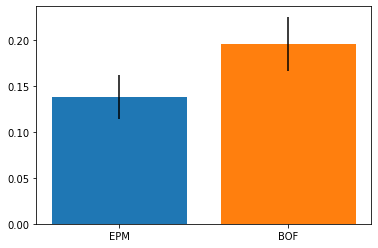

Network 2 First half - second half difference BOF vs. EPM U=25.00, pval=0.0341


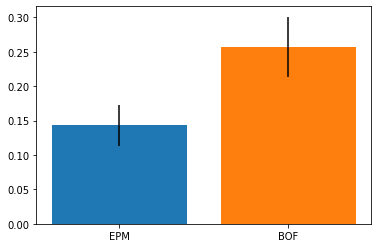

In [6]:
#Network 1
first_half_idxs = np.arange(1,151).astype(str)
last_half_idxs = np.arange(151,301).astype(str)
BOF_Periph = pd.read_csv(PROJECT_PATH + BOF_Periphery_scores.format(1))
EPM_CA = pd.read_csv(PROJECT_PATH + EPM_CA_scores.format(1))

EPM_fh_mean = np.nanmean(EPM_CA[first_half_idxs],axis=1)
EPM_lh_mean = np.nanmean(EPM_CA[last_half_idxs],axis=1)
BOF_fh_mean = np.nanmean(BOF_Periph[first_half_idxs],axis=1)
BOF_lh_mean = np.nanmean(BOF_Periph[last_half_idxs],axis=1)

EPM_diff = EPM_fh_mean - EPM_lh_mean 
BOF_diff = BOF_fh_mean - BOF_lh_mean 

result = mannwhitneyu(EPM_diff,BOF_diff,alternative="less")
print("Network 1 First half - second half difference BOF vs. EPM U={:.2f}, pval={:.4f}".format(result.statistic,result.pvalue))

#plt.figure(figsize=(20,10))
plt.bar(0,np.mean(EPM_diff))
plt.bar(1,np.mean(BOF_diff))

plt.errorbar(0,np.mean(EPM_diff),yerr=np.std(EPM_diff)/np.sqrt(11),color="black")
plt.errorbar(1,np.mean(BOF_diff),yerr=np.std(BOF_diff)/np.sqrt(9),color="black")

#plt.scatter(np.zeros((11)),EPM_diff,color="black")
#plt.scatter(np.ones((9)),BOF_diff,color="black")
plt.xticks([0,1],["EPM","BOF"])
plt.show()
#Network 2
BOF_Periph = pd.read_csv(PROJECT_PATH + BOF_Periphery_scores.format(2))
EPM_CA = pd.read_csv(PROJECT_PATH + EPM_CA_scores.format(2))

EPM_fh_mean = np.nanmean(EPM_CA[first_half_idxs],axis=1)
EPM_lh_mean = np.nanmean(EPM_CA[last_half_idxs],axis=1)
BOF_fh_mean = np.nanmean(BOF_Periph[first_half_idxs],axis=1)
BOF_lh_mean = np.nanmean(BOF_Periph[last_half_idxs],axis=1)

EPM_diff = EPM_fh_mean - EPM_lh_mean 
BOF_diff = BOF_fh_mean - BOF_lh_mean 

result = mannwhitneyu(EPM_diff,BOF_diff,alternative="less")
print("Network 2 First half - second half difference BOF vs. EPM U={:.2f}, pval={:.4f}".format(result.statistic,result.pvalue))

#plt.figure(figsize=(20,10))
plt.bar(0,np.mean(EPM_diff))
plt.bar(1,np.mean(BOF_diff))

plt.errorbar(0,np.mean(EPM_diff),yerr=np.std(EPM_diff)/np.sqrt(11),color="black")
plt.errorbar(1,np.mean(BOF_diff),yerr=np.std(BOF_diff)/np.sqrt(9),color="black")

#plt.scatter(np.zeros((11)),EPM_diff,color="black")
#plt.scatter(np.ones((9)),BOF_diff,color="black")
plt.xticks([0,1],["EPM","BOF"])
plt.show()

### Figure 3E

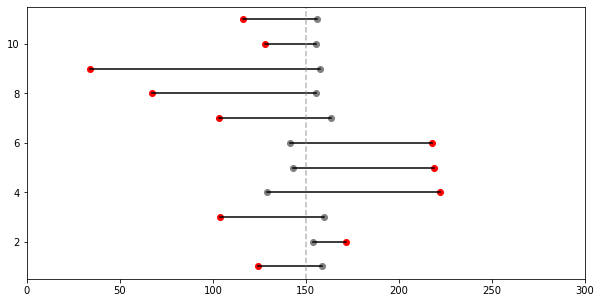

Paired two-tailed t-test result: t=-0.70,p=0.49774588


In [27]:
EPM_roi_mean_times = pd.read_csv(PROJECT_PATH + EPM_mean_times)

plt.figure(figsize=(10,5))
for i in range(EPM_roi_mean_times.shape[0]):
    plt.plot([EPM_roi_mean_times["ca_mean_time"].values[i],EPM_roi_mean_times["oa_mean_time"].values[i]],
              [i+1,i+1],
              color="black")
    
    plt.scatter(EPM_roi_mean_times["oa_mean_time"].values[i],[i+1],color="red")
    plt.scatter(EPM_roi_mean_times["ca_mean_time"].values[i],[i+1],color="gray")

plt.xlim([0,300])
plt.axvline(150,linestyle="dashed",color="grey",alpha=0.55)
plt.show()

results = ttest_rel(EPM_roi_mean_times.oa_mean_time.values,
                   EPM_roi_mean_times.ca_mean_time.values,
                   alternative="two-sided")

print("Paired two-tailed t-test result: t={:.2f},p={:.8f}".format(results.statistic,results.pvalue))

### Figure 3F

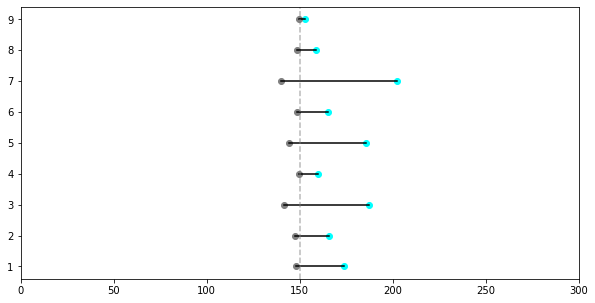

Paired two-tailed t-test result: t=3.97,p=0.00413918


In [5]:
import matplotlib.pyplot as plt
BOF_roi_mean_times = pd.read_csv(PROJECT_PATH + BOF_mean_times)

plt.figure(figsize=(10,5))

for i in range(BOF_roi_mean_times.shape[0]):
    plt.plot([BOF_roi_mean_times["center_mean_time"].values[i],BOF_roi_mean_times["surr_mean_time"].values[i]],
              [i+1,i+1],
              color="black")
    
    plt.scatter(BOF_roi_mean_times["center_mean_time"].values[i],[i+1],color="cyan")
    plt.scatter(BOF_roi_mean_times["surr_mean_time"].values[i],[i+1],color="gray")

plt.xlim([0,300])
plt.axvline(150,linestyle="dashed",color="grey",alpha=0.55)

plt.show()

results = ttest_rel(BOF_roi_mean_times.center_mean_time,
                   BOF_roi_mean_times.surr_mean_time,
                   alternative="two-sided")

print("Paired two-tailed t-test result: t={:.2f},p={:.8f}".format(results.statistic,results.pvalue))

### Figure 3G

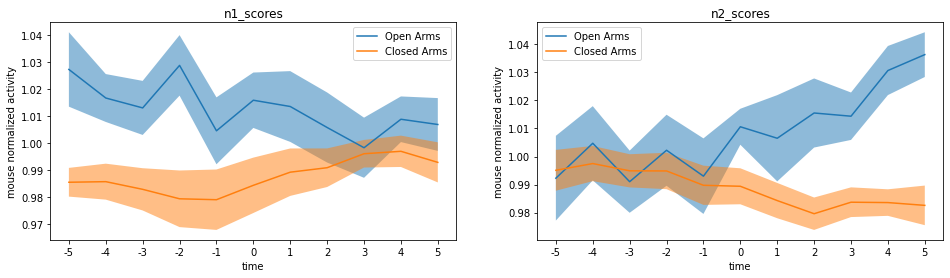

5s Prior Network 1 OA vs. CA - one-sided Wilcoxon U=55.00, p=0.0269
5s Prior Network 2 OA vs. CA - one-sided Wilcoxon U=24.00, p=0.7935
5s Post Network 1 OA vs. CA - one-sided Wilcoxon U=49.00, p=0.0874
5s Post Network 2 OA vs. CA - one-sided Wilcoxon U=62.00, p=0.0034


In [21]:
PROJECT_PATH = "/hpc/home/mk423/Anxiety/FullDataWork/Projections/"
data_file = "EPM_11s_window_stats_struct.csv"
last_five_stats_df = pd.read_csv(PROJECT_PATH + "last_5_EPM_11s_window_stats_struct.csv")
first_five_stats_df = pd.read_csv(PROJECT_PATH + "first_5_EPM_11s_window_stats_struct.csv")
stats_df = pd.read_csv(PROJECT_PATH + data_file)

plt.figure(figsize=(16,4))
for idx,score_type in enumerate(["n1_scores","n2_scores"]):
    oa_scores = []
    ca_scores = []
    t6_oa = []
    t6_ca = []
    for mouse in np.unique(stats_df.mouse):
        mouse_oa_mask = np.logical_and(stats_df.mouse==mouse,
                                       stats_df.openArms==1)
        mouse_ca_mask = np.logical_and(stats_df.mouse==mouse,
                                   stats_df.openArms==0)

        six_point_oa = stats_df[mouse_oa_mask==1][score_type].values[5]
        t6_oa.append(six_point_oa)
        six_point_ca = stats_df[mouse_ca_mask==1][score_type].values[5]
        t6_ca.append(six_point_ca)
        six_point_mean = np.mean([six_point_oa,six_point_ca])
        
        oa_scores.append(stats_df[mouse_oa_mask==1][score_type].values / six_point_mean)#/ stats_df[np.logical_and(mouse_oa_mask,
                                                                                                #stats_df.time==6)]["bxcx_n1_scores"])
        ca_scores.append(stats_df[mouse_ca_mask==1][score_type].values / six_point_mean)  #/ stats_df[np.logical_and(mouse_ca_mask,

    
    
    oa_scores = np.array(oa_scores)
    oa_mean = np.mean(oa_scores,axis=0)
    oa_std = np.std(oa_scores,axis=0) / np.sqrt(11)

    ca_scores = np.array(ca_scores)
    ca_mean = np.mean(ca_scores,axis=0) 
    ca_std = np.std(ca_scores,axis=0) / np.sqrt(11)
    #print(wilcoxon(oa_scores[:,5],ca_scores[:,6]))
    
    plt.subplot(1,2,idx+1)
    plt.plot(oa_mean,label="Open Arms")
    plt.fill_between(range(11),oa_mean+oa_std,oa_mean-oa_std,alpha=0.5)
    plt.plot(ca_mean,label="Closed Arms")
    plt.fill_between(range(11),ca_mean+ca_std,ca_mean-ca_std,alpha=0.5)
    plt.xticks(range(11),np.arange(11) - 5)
    plt.xlabel('time')
    plt.ylabel('mouse normalized activity')
    plt.title(score_type)
    plt.legend()
plt.show()

data_file = "EPM_OA_vs_CA_11_second_neighborhood_all_nets.csv"

df = pd.read_csv(PROJECT_PATH + data_file)

## Network 1
pre_idxs = np.arange(-5,0).astype(str)
post_idxs = np.arange(1,6).astype(str)
locations_idxs = ["0"]

oa_mask = np.logical_and(df.network=="n1",
                         df.location=="OpenArms")
ca_mask = np.logical_and(df.network=="n1",
                         df.location=="ClosedArms")

result = wilcoxon(np.mean(df[oa_mask==1][pre_idxs].values,axis=1),
                  np.mean(df[ca_mask==1][pre_idxs].values,axis=1),
                  alternative="greater")

print("5s Prior Network 1 OA vs. CA - one-sided Wilcoxon U={:.2f}, p={:.4f}".format(result.statistic,result.pvalue))

## Network 2

oa_mask = np.logical_and(df.network=="n2",
                         df.location=="OpenArms")
ca_mask = np.logical_and(df.network=="n2",
                         df.location=="ClosedArms")

result = wilcoxon(np.mean(df[oa_mask==1][pre_idxs].values,axis=1),
                  np.mean(df[ca_mask==1][pre_idxs].values,axis=1),
                  alternative="greater")

print("5s Prior Network 2 OA vs. CA - one-sided Wilcoxon U={:.2f}, p={:.4f}".format(result.statistic,result.pvalue))


## Network 1

oa_mask = np.logical_and(df.network=="n1",
                         df.location=="OpenArms")
ca_mask = np.logical_and(df.network=="n1",
                         df.location=="ClosedArms")

result = wilcoxon(np.mean(df[oa_mask==1][post_idxs].values,axis=1),
                  np.mean(df[ca_mask==1][post_idxs].values,axis=1),
                  alternative="greater")

print("5s Post Network 1 OA vs. CA - one-sided Wilcoxon U={:.2f}, p={:.4f}".format(result.statistic,result.pvalue))

## Network 2

oa_mask = np.logical_and(df.network=="n2",
                         df.location=="OpenArms")
ca_mask = np.logical_and(df.network=="n2",
                         df.location=="ClosedArms")

result = wilcoxon(np.mean(df[oa_mask==1][post_idxs].values,axis=1),
                  np.mean(df[ca_mask==1][post_idxs].values,axis=1),
                  alternative="greater")

print("5s Post Network 2 OA vs. CA - one-sided Wilcoxon U={:.2f}, p={:.4f}".format(result.statistic,result.pvalue))

### Figure 3H

In [2]:
df_save = pd.read_csv(PROJECT_PATH + "BOF_Center_vs_Surround_11_second_neighborhood_all_nets.csv")
df_means = pd.read_csv(PROJECT_PATH + "OFT_Holdout_mean_scores_w_agg.csv")

pre_idxs = np.arange(-5,0).astype(str)
post_idxs = np.arange(1,6).astype(str)
locations_idxs = ["0"]

5s Before:  WilcoxonResult(statistic=39.0, pvalue=0.02734375)
5s After:  WilcoxonResult(statistic=28.0, pvalue=0.28515625)


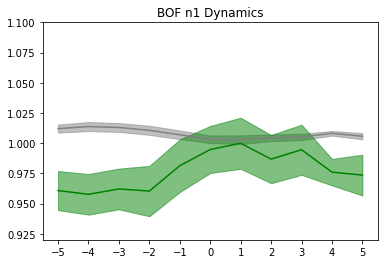

5s Before:  WilcoxonResult(statistic=37.0, pvalue=0.048828125)
5s After:  WilcoxonResult(statistic=32.0, pvalue=0.150390625)


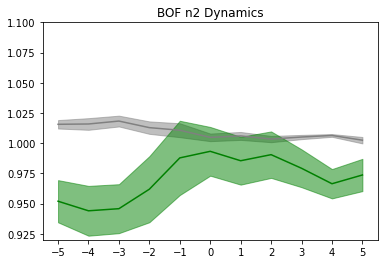

In [29]:
time_idxs = np.arange(-5,6).astype(str)

for network in ["n1","n2"]:
    if network=="n1":
        mean_key = "net 1 avgTaskScore"
    else:
        mean_key = "net 2 avgTaskScore"
        

    low_anx_mask = np.logical_and(df_save.location=="Surround",df_save.network==network)
    high_anx_mask = np.logical_and(df_save.location=="Center",df_save.network==network)
    
   
    mean_low_anx_score = df_means[mean_key].values.reshape(-1,1)
    #np.mean(df_save[low_anx_mask==1]["0"])
    mean_high_anx_score = df_means[mean_key].values.reshape(-1,1)
    #np.mean(df_save[high_anx_mask==1]["0"])

    low_anx_mean = np.mean(df_save[low_anx_mask==1][time_idxs].values / mean_low_anx_score,axis=0)
    high_anx_mean = np.mean(df_save[high_anx_mask==1][time_idxs].values / mean_high_anx_score,axis=0)
    
    low_anx_sterr = np.std(df_save[low_anx_mask==1][time_idxs].values / mean_low_anx_score,axis=0) / np.sqrt(np.unique(df_save.mouse).shape[0])
    high_anx_sterr = np.std(df_save[high_anx_mask==1][time_idxs].values / mean_high_anx_score,axis=0) / np.sqrt(np.unique(df_save.mouse).shape[0])
    
    print("5s Before: ", wilcoxon(np.mean(df_save[low_anx_mask==1][pre_idxs].values,axis=1),
                                  np.mean(df_save[high_anx_mask==1][pre_idxs].values,axis=1),
                                  alternative="greater"))
    
    print("5s After: ", wilcoxon(np.mean(df_save[low_anx_mask==1][post_idxs].values,axis=1),
                                  np.mean(df_save[high_anx_mask==1][post_idxs].values,axis=1),
                                  alternative="greater"))
    
    
    plt.plot(np.arange(-5,6),low_anx_mean,color="grey")
    plt.fill_between(np.arange(-5,6), low_anx_mean + low_anx_sterr, low_anx_mean - low_anx_sterr, alpha=0.5,color="grey")
    
    plt.plot(np.arange(-5,6),high_anx_mean,color="green")
    plt.fill_between(np.arange(-5,6), high_anx_mean + high_anx_sterr, high_anx_mean - high_anx_sterr, alpha=0.5,color="green")
    
    plt.ylim([0.92,1.1])
    plt.xticks(np.arange(-5,6))
    plt.title("BOF {} Dynamics".format(network))
    plt.show()